In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk 
import gensim
import torch
import os

In [38]:
k=0

In [39]:
from keras.utils import pad_sequences

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import spacy
import numpy as np

import random
import math
import time

In [41]:
import warnings
import numpy as np 
import pandas as pd 

import os
import torch
import torch.nn as nn 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [42]:
warnings.filterwarnings('ignore')
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from   torchtext.vocab import FastText
import nltk
from nltk import ngrams
from nltk.stem import WordNetLemmatizer as wnl
import torchtext.vocab as vocab
import fasttext
from torch.utils.data import Dataset ,DataLoader


In [43]:
import nltk
import string
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
!pip install pytorch-nlp 

In [45]:
import datasets
from datasets import load_dataset


In [46]:
french_stopwords = nltk.corpus.stopwords.words('french')
english_stopwords = nltk.corpus.stopwords.words('english')


In [47]:
import re
def clean_text(txt):
        txt = txt.lower()
        txt = re.sub(r"i'm", "i am", txt)
        txt = re.sub(r"he's", "he is", txt)
        txt = re.sub(r"she's", "she is", txt)
        txt = re.sub(r"that's", "that is", txt)
        txt = re.sub(r"what's", "what is", txt)
        txt = re.sub(r"where's", "where is", txt)
        txt = re.sub(r"\'ll", " will", txt)
        txt = re.sub(r"\'ve", " have", txt)
        txt = re.sub(r"\'re", " are", txt)
        txt = re.sub(r"\'d", " would", txt)
        txt = re.sub(r"won't", "will not", txt)
        txt = re.sub(r"can't", "can not", txt)
        txt = re.sub(r"[^\w\s]", "", txt)
        return txt
def preprocess (x):
    global vocab 
    x=clean_text(x)
    x=''.join([i   for i in x if not i in string.punctuation])
    x=nltk.word_tokenize(x.lower(), language='english')
    x=[i if not i.isdigit() else 'num'for i in x ]
    x=['<s>']+list(x)+[r'<\s>']
    #x=[i  for i in x if not i in english_stopwords]
  
    x=pad_sequences([x],maxlen=25,value='<pad>', padding='post',dtype=object)[0]
    return list(x)

In [48]:
data=pd.read_csv("/kaggle/input/cleaned-data-for-the-chatbot-collected-from-movies/dialogs_expanded.csv")

In [49]:
data.drop(columns=['Unnamed: 0'],inplace=True)

In [50]:
data.iloc[:,0]=data.iloc[:,0].apply(lambda x:preprocess(x) )
data.iloc[:,1]=data.iloc[:,1].apply(lambda x:preprocess(x) )

In [51]:
import torchtext.vocab as vocab


In [52]:
vocab_en=vocab.build_vocab_from_iterator(data.iloc[:,0]+data.iloc[:,1], specials=['<unk>', '<pad>','<s>','<\s>'])


In [53]:
v_en=vocab_en.get_stoi()


In [56]:
def change(x):
    x=[v_en.get(i,v_en['<pad>']) for i in x]
    return x

In [57]:
data.iloc[:,0]=data.iloc[:,0].apply(lambda x:change(x) )
data.iloc[:,1]=data.iloc[:,1].apply(lambda x:change(x) )


In [58]:
class dataset(Dataset):
    def __init__(self,x,y):
         self.x=x
         self.y=y
    def __len__(self):
        return len(self.x) 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

In [59]:
x=torch.tensor(data.iloc[:,0].tolist())
y=torch.tensor(data.iloc[:,1].tolist())

In [60]:
train=dataset(x[:100000],y[:100000])
valid=dataset(x[125000:],y[125000:])
train_set=DataLoader(train,batch_size=32,shuffle =True)
valid_set=DataLoader(valid,batch_size=32,shuffle =True)

In [61]:
class encode(nn.Module):
    def __init__(self):
        super(encode,self).__init__()
        self.emb=nn.Embedding(len(v_en),300)
        self.lstm=nn.GRU(300,1024,bidirectional=True,batch_first=True,dropout=.3)
        self.linear_h=nn.Linear(2048,1028)
    def forward(self,x):
        x=self.emb(x).cuda()
        x,h=self.lstm(x)  
        #h=torch.cat((h[1].cuda(),h[0].cuda() ),dim=1)
        return x.cuda(),h.cuda()    
    
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
      #  print(query.shape,keys.shape)
        scores = self.Va(torch.tanh(self.Wa(query.unsqueeze(1).repeat(1,keys.shape[1],1)) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights
class decode (nn.Module):
     def __init__(self):
        super(decode,self).__init__()
        self.emb=nn.Embedding(len(v_en),300)
        self.lstm=nn.GRU(2348,1024,bidirectional=True,batch_first=True,dropout=.3)
        self.linear=nn.Linear(2048,len(v_en))
        self.linear2=nn.Linear(2048,1)
        self.att=BahdanauAttention(2048)
     def forward (self,x,states,h):  
                x=x.unsqueeze(1).cuda()
                x=self.emb(x).cuda() 
                h2=torch.cat((h[1].cuda(),h[0].cuda() ),dim=1)

                context,att=self.att(h2,states)
               # states=states.permute(0,2,1).cuda()
             #   print(context.shape,att.shape)
            #    att=att.permute(0,2,1).cuda() 

             #   weighted = torch.bmm(att, states).cuda()
             #   weighted = weighted.permute(1, 0, 2).cuda()
                #weighted = [1, batch size, enc hid dim * 2]
                rnn_input = torch.cat((x, context), dim = 2).cuda()
                x1,h1=self.lstm(rnn_input,h.cuda())
                x1= self.linear(x1.cuda()).cuda()
                x1=x1.squeeze(1).cuda()

                return x1.cuda(),h1
            

In [62]:
class seq2seq (nn.Module):
    def __init__(self):
        super(seq2seq,self).__init__()
        self.decode=decode().cuda()
        self.encode=encode().cuda()
    def forward(self,x,target,epoch):
        states,h=self.encode(x)
        batch=x.shape[0]      
        length=x.shape[1]
        y=target[:,0]
        ans=torch.zeros(batch,length,len(v_en)).cuda()
        for t in range(1,length):
            out,h=self.decode(y,states,h) 
            ans[:,t,:]=out
            y=  target[:,t] 
        return ans 
    def one_forward(self,x):
        states,h=self.encode(x)
        batch=x.shape[0]      
        length=x.shape[1]
        y=x[:,0]
        ans=torch.zeros(batch,length).cuda()
        for t in range(1,length):
            out,h=self.decode(y,states,h) 
            ans[:,t]=torch.argmax(out,dim=1)
            y= torch.argmax(out,dim=1)
        return ans 

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [64]:
model =seq2seq().cuda()
loss=nn.CrossEntropyLoss(ignore_index=v_en['<pad>'])
optim=torch.optim.Adam(model.parameters())
schedular=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,verbose=True,patience=5)

In [27]:
l_train=[]
v_train=[]
for i in range(0,20):
    model.train()
    t_l=0
    o=0
    a_t=0
    for (a,b) in train_set:
        r=model(a.cuda(),b.cuda(),i)
        r=r[1:].view(-1,r.shape[-1])
        l=loss(r,b[1:].cuda().reshape(-1))
        optim.zero_grad()
        l.backward()
        optim.step()
        t_l+=l.item()
        o+=1
#        k=calculate_accuracy(r,c.cuda())
        a_t+=k        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(f"\r iter {o}  train loss {l.item()} , accuracy : { k}",end='')
    v_l=0
    model.eval()
    print()
    a_v=0
    with torch.no_grad():
        for (a,b) in valid_set:
            r=model(a.cuda(),b.cuda(),i)
            r=r.view(-1,r.shape[-1])
            l=loss(r,b.cuda().reshape(-1))
            v_l+=l.item()
            a_v+=k
    schedular.step(v_l)
    l_train.append(t_l)
    v_train.append(v_l)
    if (i==10):
        torch.save(model,'model_all.pth')
        torch.save(model,'model_dict.pt')
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")

 iter 3125  train loss 5.709682464599609 , accuracy : 0

0 train loss: 5.606154963684082 accuracy : 0.0  , valid : 5.4796949987136605 accuracy : 0.0

 iter 3125  train loss 5.006477355957031 , accuracy : 0

1 train loss: 4.8324470738220215 accuracy : 0.0  , valid : 5.586840934076753 accuracy : 0.0

 iter 3125  train loss 4.244003772735596 , accuracy : 0

2 train loss: 3.9142035150909424 accuracy : 0.0  , valid : 5.973596701865186 accuracy : 0.0

 iter 3125  train loss 3.5866410732269287 , accuracy : 0

3 train loss: 3.3681735789489746 accuracy : 0.0  , valid : 6.3771875523146395 accuracy : 0.0

 iter 3125  train loss 3.2224392890930176 , accuracy : 0

4 train loss: 2.9616509590148925 accuracy : 0.0  , valid : 6.817442712128295 accuracy : 0.0

 iter 3125  train loss 2.990349531173706 , accuracy : 0

5 train loss: 2.658524476928711 accuracy : 0.0  , valid : 7.220978181800927 accuracy : 0.0

 iter 3125  train loss 2.659461498260498 , accuracy : 0

Epoch 00007: reducing learning rate of gr

In [28]:
torch.save(model,'model_all2.pth')
torch.save(model,'model_dict2.pt')

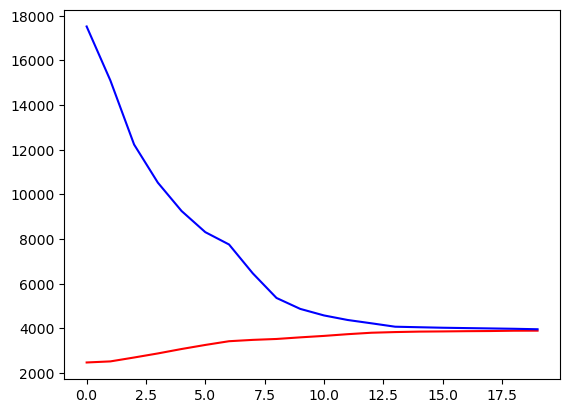

In [29]:
from matplotlib import pyplot as plt
plt.plot (list(v_train),c='r')
plt.plot (list(l_train),c='b')


In [65]:
idx_fr=vocab_en.get_itos()

In [67]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def to_chat(x):
    x=preprocess(x)
    return change(x)
def from_chat(x)   :
    x=[idx_fr[int(i.item())] for i in x[0] ]
    
    return ' '.join(x[1:x.index('<\s>')])

In [68]:
def ask(x):
    x=model.one_forward(torch.tensor([to_chat(x)]).cuda())
    print(from_chat(x))

In [69]:
ask("what is your name")
ask("what are they call you")
ask("can you tell me about the life and it is meaning")
ask("who is your father")
ask("i am sad of your")

you are in my head you dont know my name
i have no idea what is going on
i dont know
my father he is not an me to take it
is that what you did see you
